In [1]:
import sys
import wfdb
import re
import pandas as pd
import plotly.express as px
from pathlib import Path
from collections import Counter

# ECG Data Exploration

- Data contains 12-lead electrocardiogram (ECG) signals of 45,152 patients with a 500 Hz sampling rate.
- The tests were taken over a period of 10 seconds.

In [2]:
# Define Paths
ROOT = Path.cwd().parent
DATASET = ROOT / "data" / "files" / "ecg-arrhythmia" / "1.0.0" / "WFDBRecords"

## Conditions

In [3]:
DATA = ROOT / "data" / "files" / "ecg-arrhythmia" / "1.0.0"
conditions = pd.read_csv(DATA / "ConditionNames_SNOMED-CT.csv")
conditions.head()

,Acronym Name,Full Name,Snomed_CT
0,1AVB,1 degree atrioventricular block,270492004
1,2AVB,2 degree atrioventricular block,195042002
2,2AVB1,2 degree atrioventricular block(Type one),54016002
3,2AVB2,2 degree atrioventricular block(Type two),28189009
4,3AVB,3 degree atrioventricular block,27885002


In [4]:
headers = list(DATASET.rglob("*.hea"))

found_codes = set()
for hea in headers:
    for line in hea.read_text().splitlines():
        if line.startswith("#Dx:"):
            codes = re.split(r"[,:]", line.split(":",1)[1])
            found_codes.update(c.strip() for c in codes if c.strip())

all_codes = set(conditions["Snomed_CT"].astype(str))

missing_in_data = all_codes - found_codes
extra_in_data = found_codes - all_codes

print(f"SNOMED codes present in dataset: {len(found_codes)}")
print(f"Codes listed in your ConditionNames_SNOMED-CT.csv file: {len(all_codes)}")
print(f"Codes in the CSV but not found in any ECG header: {len(missing_in_data)}")
print(f"Codes found in ECGs but not listed in the CSV: {len(extra_in_data)}")

SNOMED codes present in dataset: 94
Codes listed in your ConditionNames_SNOMED-CT.csv file: 55
Codes in the CSV but not found in any ECG header: 4
Codes found in ECGs but not listed in the CSV: 43


## Check one record

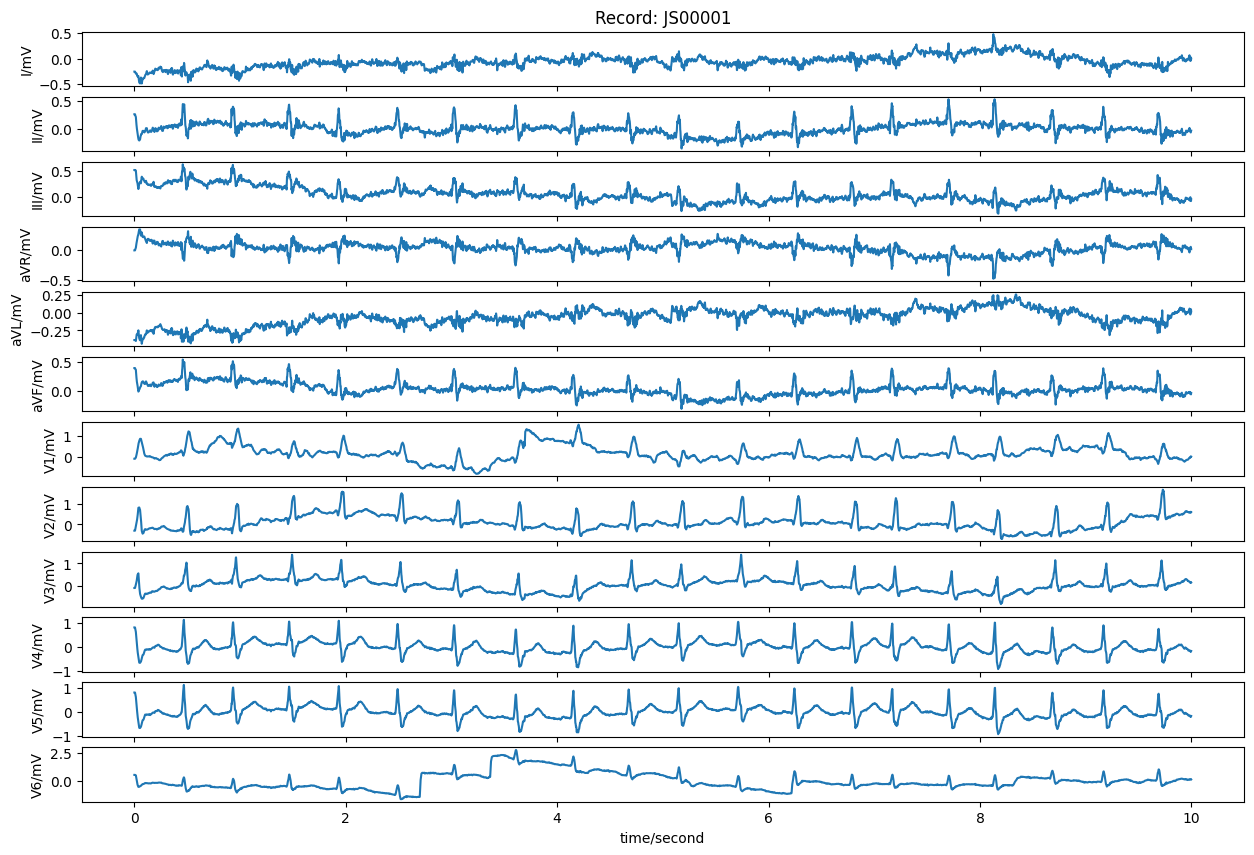

In [5]:
record_path = DATASET / "01" / "010" / "JS00001"
record = wfdb.rdrecord(record_path)
wfdb.plot_wfdb(record=record, figsize=(15,10))

In [6]:
conditions.columns.tolist()

['Acronym Name', 'Full Name', 'Snomed_CT']

In [7]:
hea_path = record_path.with_suffix(".hea")
txt = hea_path.read_text()

dx_line = next((l for l in txt.splitlines() if l.startswith('#Dx:')), None)
codes = [] if dx_line is None else [c.strip() for c in dx_line.split(':',1)[1].split(',') if c.strip()]

code_col = "Snomed_CT"
name_col = "Full Name"

labels = conditions[conditions[code_col].astype(str).isin(codes)][[code_col, name_col]]
labels


,Snomed_CT,Full Name
35,59118001,right bundle branch block
41,164934002,T wave Change
54,164889003,Atrial Fibrillation


In [8]:
# uses existing ROOT, DATASET, DATA, conditions

# ensure mapping key is str
conditions["Snomed_CT"] = conditions["Snomed_CT"].astype(str)
code2name = dict(zip(conditions["Snomed_CT"], conditions["Full Name"]))

# collect Dx codes from all headers
codes_all = []
for hea in DATASET.rglob("*.hea"):
    for line in hea.read_text().splitlines():
        if line.startswith("#Dx:"):
            tail = line.split(":", 1)[1]
            codes_all.extend(t for t in tail.replace(",", " ").split() if t)

# frequency dataframe (Snomed_CT, count, name)
freq_df = (
    pd.Series(codes_all, name="Snomed_CT")
      .value_counts()
      .rename_axis("Snomed_CT")
      .reset_index(name="count")
      .assign(name=lambda d: d["Snomed_CT"].map(code2name).fillna("(unmapped)"))
)

In [9]:
TOP_N = 20
top = (freq_df.head(TOP_N)
       .astype({"Snomed_CT": str})
       .sort_values("count", ascending=True)  # horizontal bars
       .assign(status=lambda d: d["name"].eq("(unmapped)").map({True:"Unmapped", False:"Mapped"})))

fig = px.bar(
    top, x="count", y="Snomed_CT", color="status",
    orientation="h", title=f"Top {TOP_N} SNOMED codes by frequency",
    labels={"count": "# records", "Snomed_CT": "SNOMED CT code", "status": ""}
)

fig.update_layout(
    height=30 * len(top) + 140,                 # taller plot
    margin=dict(l=160, r=20, t=60, b=40)        # more left margin
)
fig.update_yaxes(
    automargin=True,
    tickfont=dict(size=12),
    categoryorder="array",                      # keep your order
    categoryarray=top["Snomed_CT"].tolist()
)

fig.show()

## Run compare_metrics.py

In [10]:
%cd ..
!python scripts/prepare_metrics.py --root "{DATA}" --topn 20

/Users/katherine/Desktop/Projects/ecg-arrhythmia-dashboard
Wrote: /Users/katherine/Desktop/Projects/ecg-arrhythmia-dashboard/dashboard/data/metrics.json and /Users/katherine/Desktop/Projects/ecg-arrhythmia-dashboard/dashboard/data/top_codes.csv


# Physionet Data Folder Tree

In [11]:
def compact_tree(root: Path, max_depth=2, max_items=12,
                 ignore=(".ipynb_checkpoints", ".DS_Store")):
    root = Path(root)
    out = [root.name]

    def walk(p: Path, pref: str, depth: int):
        if depth > max_depth:
            return
        kids = [x for x in sorted(p.iterdir(), key=lambda x: (x.is_file(), x.name.lower()))
                if x.name not in ignore]
        shown = kids[:max_items]
        hidden = len(kids) - len(shown)
        for i, x in enumerate(shown):
            last = (i == len(shown)-1 and hidden == 0)
            out.append(f"{pref}{'└── ' if last else '├── '}{x.name}")
            if x.is_dir():
                walk(x, pref + ("    " if last and hidden == 0 else "│   "), depth+1)
        if hidden > 0:
            out.append(f"{pref}└── … (+{hidden} more)")

    walk(root, "", 1)
    return "\n".join(out)

# overview of 1.0.0 (includes files like robots.txt, LICENSE.txt, etc.)
print(compact_tree(DATA, max_depth=2, max_items=12))


1.0.0
├── WFDBRecords
│   ├── 01
│   ├── 02
│   ├── 03
│   ├── 04
│   ├── 05
│   ├── 06
│   ├── 07
│   ├── 08
│   ├── 09
│   ├── 10
│   ├── 11
│   ├── 12
│   └── … (+35 more)
├── ConditionNames_SNOMED-CT.csv
├── index.html
├── LICENSE.txt
├── RECORDS
└── SHA256SUMS.txt


In [12]:
def record_summary(rec_dir: Path, sample_pairs: int = 8):
    rec_dir = Path(rec_dir)

    heas = sorted(rec_dir.glob("*.hea"))
    mats = sorted(rec_dir.glob("*.mat"))
    stems_hea = {p.stem for p in heas}
    stems_mat = {p.stem for p in mats}
    paired = sorted(stems_hea & stems_mat)

    has_index = (rec_dir / "index.html").exists()

    # header
    print(rec_dir)
    print(rec_dir.name)
    # lines
    print("├── index.html" if has_index else "├── (no index.html)")
    print(f"├── .hea files: {len(heas)}")
    print(f"├── .mat files: {len(mats)}")
    print(f"├── paired records (.hea+.mat): {len(paired)}")
    print("└── samples:")
    for i, s in enumerate(paired[:sample_pairs]):
        branch = "    ├──" if i < min(sample_pairs, len(paired)) - 1 else "    └──"
        print(f"{branch} {s}.hea, {s}.mat")
    if len(paired) > sample_pairs:
        print(f"        … (+{len(paired) - sample_pairs} more pairs)")

# pick a record folder and show compact summary
leaf = None
for p in DATASET.rglob("*"):
    if p.is_dir() and (list(p.glob("*.hea")) or list(p.glob("*.mat"))):
        leaf = p
        break

record_summary(leaf, sample_pairs=8)


/Users/katherine/Desktop/Projects/ecg-arrhythmia-dashboard/data/files/ecg-arrhythmia/1.0.0/WFDBRecords/03/038
038
├── index.html
├── .hea files: 100
├── .mat files: 100
├── paired records (.hea+.mat): 100
└── samples:
    ├── JS02924.hea, JS02924.mat
    ├── JS02925.hea, JS02925.mat
    ├── JS02926.hea, JS02926.mat
    ├── JS02927.hea, JS02927.mat
    ├── JS02928.hea, JS02928.mat
    ├── JS02929.hea, JS02929.mat
    ├── JS02930.hea, JS02930.mat
    └── JS02931.hea, JS02931.mat
        … (+92 more pairs)


## Run describe_data.py

In [18]:
!python "/Users/katherine/Desktop/Projects/ecg-arrhythmia-dashboard/scripts/describe_dataset.py" \
  --root "{DATA}" \
  --outdir "/Users/katherine/Desktop/Projects/ecg-arrhythmia-dashboard/dashboard/data"


Wrote /Users/katherine/Desktop/Projects/ecg-arrhythmia-dashboard/dashboard/data/structure.json
